In [1]:
### Helper Function Section
### This section includes the helper functions, which are introduced during lecture and in code template
### draw_lines() function is defined in this section.
### Descriptions for the other functions are left unchanged.

### Import the libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from scipy.optimize import curve_fit
%matplotlib inline

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, vertices, color=[255, 0, 0], thickness=10):
    # draw_lines() function is called after Hough transformation. 
    # This function uses the output lines of Hough transformation.
    # draw_lines() allows to create 2 solid lines for left and right lane lines by processing Hough transformation output
    
    # Initialization
    AllLines = []
    MinSlope = 0.2  # Minimum slope value to select a line 
    MaxSlope = 2 # Maximum slope value to select a line 
    SlopeThd = 0.05 # Threshold for comparison with average slope
    
    # AllLines is the variable which stores the slope information of all lines generated by Hough transfomration
    for pltline in lines:
        for x1,y1,x2,y2 in pltline:
            #plt.plot([x1, x2], [y1, y2])
            AllLines.extend([(y2-y1)/(x2-x1)])
    LinePos = [i for i in AllLines if i > 0 and abs(i) > MinSlope and abs(i) < MaxSlope] # Lines with positive slope (expectdly right lane): Will be called as positive lines
    LineNeg = [i for i in AllLines if i <= 0 and abs(i) > MinSlope and abs(i) < MaxSlope] # Lines with negative slope (expectdly left lane): Will be called as negative lines
    
    # Finding (x,y) coordinates of the lines 
    # If the absolute difference between line slope and average slope is below a threshold, that line is eliminated.
    if not len(LineNeg):
        NegLines = []
    else:
        LineAbsNeg = sum(LineNeg)/len(LineNeg) # Average of negative lines slopes
        LineNegLim = [i for i in LineNeg if abs(i-LineAbsNeg) < SlopeThd] # Average slope comparison
        NegLines = [lines[AllLines.index(i)] for i in LineNegLim] # (x,y) coordinates of the negative lines
    
    if not len(LinePos):
        PosLines = []
    else:
        LineAbsPos = sum(LinePos)/len(LinePos) # Average of positive lines slopes
        LinePosLim = [i for i in LinePos if abs(i-LineAbsPos) < SlopeThd] # Average slope comparison
        PosLines = [lines[AllLines.index(i)] for i in LinePosLim] # (x,y) coordinates of the positive lines
     
    # X and Y points of the lines are separated.
    # Since it is expected to have negative lines on the left side of the image (compared to middle), negative lines on the right side of the image are eliminated.
    # Since it is expected to have positive lines on the right side of the image (compared to middle), positive lines on the left side of the image are eliminated.
    xCurveDataNeg = np.array([])
    yCurveDataNeg = np.array([])
    if len(NegLines):
        for pltline in NegLines:
            for x1,y1,x2,y2 in pltline:
                #plt.plot([x1, x2], [y1, y2],'*b')
                xCurveDataNeg = np.concatenate((xCurveDataNeg,np.array([x1, x2])))
                yCurveDataNeg = np.concatenate((yCurveDataNeg,np.array([y1, y2])))
        xLimNeg = img.shape[1]/2
        SearchIndexNeg = (xCurveDataNeg < xLimNeg)
        yCurveDataNeg = yCurveDataNeg[SearchIndexNeg] # X coordinates of negative lines
        xCurveDataNeg = xCurveDataNeg[SearchIndexNeg] # Y coordinates of negative lines
        
    xCurveDataPos = np.array([])
    yCurveDataPos = np.array([])
    if len(PosLines):
        for pltline in PosLines:
            for x1,y1,x2,y2 in pltline:
               #plt.plot([x1, x2], [y1, y2],'*r')
                xCurveDataPos = np.concatenate((xCurveDataPos,np.array([x1, x2])))
                yCurveDataPos = np.concatenate((yCurveDataPos,np.array([y1, y2])))
        xLimPos = img.shape[1]/2
        SearchIndexPos = (xCurveDataPos > xLimPos)
        yCurveDataPos = yCurveDataPos[SearchIndexPos] # X coordinates of positive lines
        xCurveDataPos = xCurveDataPos[SearchIndexPos] # Y coordinates of positive lines
    
    # Definition of curve fit (line fit) function and inverse line fit function
    def CurveFitFunc(x, a, b):
        return a * x + b
    def CurveFitFuncInv(y, a, b):
        return (y-b) / a
    
    
    if not yCurveDataNeg.any():
        LineNeg = []
    else:
        popt, pcov = curve_fit(CurveFitFunc, xCurveDataNeg, yCurveDataNeg) # Line fit for X and Y coordiantes for negative lines
        yLimNeg = vertices[0][1][1] # Left upper corner Y position of region of interest
        yMax = img.shape[0] # Left lower corner Y position of region of interest
        xStartNeg = CurveFitFuncInv(yMax, *popt) # X position corresponding to left upper corner Y position using fitted line
        xEndNeg = CurveFitFuncInv(yLimNeg, *popt) # X position corresponding to left lower corner Y position using fitted line
        LineNeg = [xStartNeg,yMax,xEndNeg,yLimNeg] # Fitted Line for left side of the image
        LineNeg = [int(i) for i in LineNeg] # Fitted Line coordinates for left side of the image
    #plt.plot(xCurveDataNeg, CurveFitFunc(xCurveDataNeg, *popt), 'b-',)
    
    if not yCurveDataPos.any():
        LinePos = [] 
    else:
        popt, pcov = curve_fit(CurveFitFunc, xCurveDataPos, yCurveDataPos) # Line fit for X and Y coordiantes for positive lines
        yLimPos = vertices[0][2][1] # Right upper corner Y position of region of interest
        yMax = img.shape[0] # # Right lower corner Y position of region of interest
        xStartPos = CurveFitFuncInv(yMax, *popt) # X position corresponding to right upper corner Y position using fitted line
        xEndPos = CurveFitFuncInv(yLimPos, *popt) # X position corresponding to right lower corner Y position using fitted line
        LinePos = [xStartPos,yMax,xEndPos,yLimPos] # Fitted Line for right side of the image
        LinePos = [int(i) for i in LinePos] # Fitted Line coordinates for right side of the image
    #plt.plot(xCurveDataPos, CurveFitFunc(xCurveDataPos, *popt), 'r-',)
    
    # Fitted lines with user defined color and thickness
    LinesFit = np.array([[LineNeg],[LinePos]])
    plt.show()
    #for pltline in LinesFit:
        #for x1,y1,x2,y2 in pltline:
            #plt.plot([x1, x2], [y1, y2],'k')
    if LinePos and LineNeg:
        for line in LinesFit:
            for x1,y1,x2,y2 in line:
                cv2.line(img,(x1,y1),(x2,y2),color,thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, vertices)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [2]:
### Pipeline Section
### This section includes the pipeline
### process_image() function calls the helper functions. Parameter values are introduced in this section.
### Example Usage: UpdatedImage = process_image(Image) command gives the image with detected lines on it.
### Notice: plot commands are commented

def process_image(image):
    gray = grayscale(image)
    #plt.imshow(gray, cmap='gray')
    #plt.show()

    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    #plt.imshow(blur_gray, cmap='gray')
    #plt.show()

    low_threshold = 50
    high_threshold = 150
    masked_edges = canny(blur_gray, low_threshold, high_threshold)
    #plt.imshow(masked_edges, cmap='gray')
    #plt.show()

    imshape = image.shape
    xUpperLeft = 470
    xUpperRight = 490
    yUpper = 315
    vertices = np.array([[(0,imshape[0]),(xUpperLeft, yUpper), (xUpperRight, yUpper), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(masked_edges, vertices)
    #plt.imshow(masked_image, cmap='gray')
    #plt.show()

    rho = 2
    theta = 1*np.pi/180
    threshold = 15
    min_line_len = 20
    max_line_gap = 25
    line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap, vertices)
    #plt.imshow(line_img)
    #plt.show()

    color_edges = np.dstack((masked_edges, masked_edges, masked_edges))
    combox = cv2.addWeighted(color_edges, 0.8, line_img, 1, 0) 
    #plt.imshow(combox)
    #plt.show()

    result = weighted_img(line_img, image, α=0.8, β=1., γ=0.)
    #plt.imshow(result)
    #plt.show()
    return result 

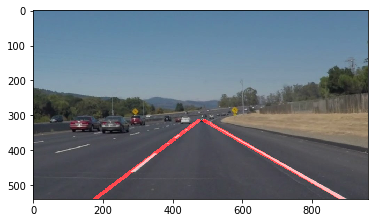

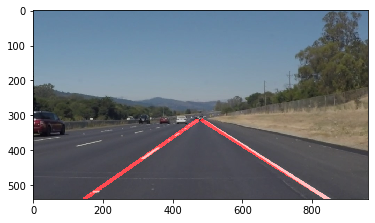

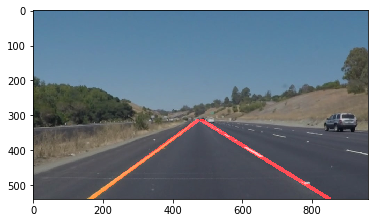

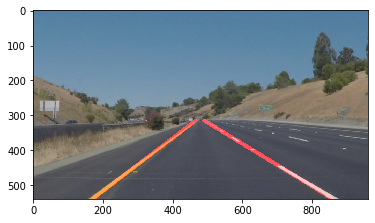

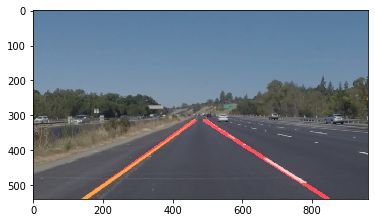

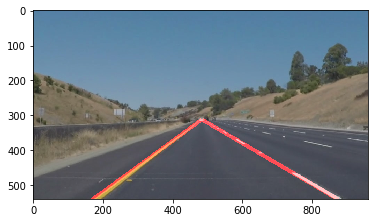

In [3]:
### This section allows to load all images from "test_images" and process them to find lane lines
### Notice: Uncomment the cv2.imwrite command to save the files in "test_images_output"
import os
from matplotlib import pyplot as plt

ReadDirectory = 'test_images/'
SaveDirectory = 'test_images_output/'
for file in os.listdir(ReadDirectory): 
    image = mpimg.imread(ReadDirectory+file)
    imageOut = process_image(image)
    plt.imshow(imageOut) 
    #cv2.imwrite(SaveDirectory+file, cv2.cvtColor(imageOut, cv2.COLOR_BGR2RGB))

In [5]:
### This section allows to load a video and process it to find lane lines. Video will be played directly during process.
cap = cv2.VideoCapture('test_videos/solidWhiteRight.mp4')
#cap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')
vid_cod = cv2.VideoWriter_fourcc(*'XVID')
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret: 
        UpdatedPicture = process_image(frame)   
        cv2.imshow('frame',UpdatedPicture)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [6]:
### This section allows to load solidWhiteRight video and process it to find lane lines. Video will be played after saving the file.
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 6.63 s


In [8]:
### This section allows to load solidYellowLeft video and process it to find lane lines. Video will be played after saving the file.
from moviepy.editor import VideoFileClip
from IPython.display import HTML

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 6.33 s
